In [3]:
import models
from loader import Loader
from copy import deepcopy
import torch
from itertools import product

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import torch

from edit_heuristics import FromLayerHeuristic, SingleLayerHeuristic, ActivationBased, WeightsActivationBased
from set_heuristics import SetHeuristic, SubsetSetHeuristic, SimilaritySetHeuristic, MisclassifiedSetHeuristic, ByClassSetHeuristic
from IPython.display import clear_output

ROOT = "./data"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = f"{ROOT}/moon_classifier_mlp.pth"
DATASET_PATH = f"{ROOT}/moon_dataset.pt"
EDITSET_PATH = f"{ROOT}/moon_misclassifications.pt"
EDITED_MODEL_PATH = f"{ROOT}/moon_classifier_mlp_edited.pth"

original_model = models.mlp(path=MODEL_PATH)
moon_data = torch.load(DATASET_PATH)
moon_dataset = torch.utils.data.TensorDataset(moon_data['features'], moon_data['labels'])

# Get the test data features and labels from the moon_dataset
X = moon_data['features']
y = moon_data['labels']

# Test all possible combinations of heuristics

# Define all heuristic options
edit_heuristics_options = [
    ("SingleLayer", SingleLayerHeuristic(layer_idx=-1, lb=-0.5, ub=0.5)),
    ("FromLayer", FromLayerHeuristic(start_layer=-1, lb=-0.5, ub=0.5)),
    ("ActivationBased", ActivationBased(dataset=moon_dataset, lb=-0.5, ub=0.5)),
    ("WeightsActivationBased", WeightsActivationBased(dataset=moon_dataset, lb=-0.1, ub=0.1, threshold=0.9))
]

# Load original model for use in new heuristics
original_model_for_heuristics = models.mlp(path=MODEL_PATH)

set_heuristics_options = [
    # ("SubsetSetHeuristic", SubsetSetHeuristic(filename=EDITSET_PATH, indices=[0, 1, 2, 3, 4, 5])),
    ("SimilaritySetHeuristic", SimilaritySetHeuristic(filename=EDITSET_PATH, device=DEVICE, dtype=torch.float32, similarity_threshold=0.9999999999)),
    ("MisclassifiedSetHeuristic", MisclassifiedSetHeuristic(filename=EDITSET_PATH, device=DEVICE, dtype=torch.float32, max_samples=10)),
    ("ByClassSetHeuristic_Blue", ByClassSetHeuristic(dataset=moon_dataset, target_class=0, device=DEVICE, dtype=torch.float32, max_samples=-1)),
    ("ByClassSetHeuristic_Red", ByClassSetHeuristic(dataset=moon_dataset, target_class=1, device=DEVICE, dtype=torch.float32, max_samples=-1))
]

print(f"Total combinations to test: {len(edit_heuristics_options)} edit × {len(set_heuristics_options)} set = {len(edit_heuristics_options) * len(set_heuristics_options)} combinations")

# Store results organized by set heuristic
results_by_set = {}
for set_name, _ in set_heuristics_options:
    results_by_set[set_name] = []

print("Testing all combinations of heuristics...")
for (edit_name, edit_heur), (set_name, set_heur) in product(edit_heuristics_options, set_heuristics_options):
    try:
        test_loader = Loader(
            model=deepcopy(original_model),
            edit_heuristic=edit_heur,
            set_heuristic=set_heur,
            dataset=moon_dataset,
        )
        
        # Edit and test model
        test_loader.edit_and_test_model()
        
        # Get edited model predictions
        with torch.no_grad():
            outputs = test_loader.model(X)
            _, predicted = torch.max(outputs.data, 1)
            accuracy = (predicted.numpy() == y.numpy()).mean()
        
        result = {
            'edit_heuristic': edit_name,
            'set_heuristic': set_name,
            'model': deepcopy(test_loader.model),
            'accuracy': accuracy,
            'combination': f"{edit_name} + {set_name}"
        }
        
        results_by_set[set_name].append(result)
        
        print(f"Accuracy: {accuracy:.4f}")
        
    except Exception as e:
        print(f"Error with {edit_name} + {set_name}: {str(e)}")
        print(f"Skipping this combination...")

# Clear any previous outputs/plots
# clear_output(wait=True)

# Parameters for visualization
h = 0.02
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
mesh_input = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])


# Plot original model in center of first row
with torch.no_grad():
    mesh_output = original_model(mesh_input)
    Z = torch.argmax(mesh_output, dim=1).reshape(xx.shape).detach().numpy()
    original_outputs = original_model(X)
    _, original_predicted = torch.max(original_outputs.data, 1)

# Calculate accuracy of original model
original_predicted = original_predicted.numpy()
original_accuracy = (original_predicted == y.numpy()).mean()

# Flatten results for finding best
all_results = []
for set_results in results_by_set.values():
    all_results.extend(set_results)

if all_results:
    best_result = max(all_results, key=lambda x: x['accuracy'])
    print(f"\nBest combination: {best_result['combination']} with accuracy: {best_result['accuracy']:.4f}")
    print(f"Successfully tested {len(all_results)} out of {len(edit_heuristics_options) * len(set_heuristics_options)} combinations")
    
    # Print detailed comparison organized by set heuristic
    print("\n" + "="*120)
    print("DETAILED RESULTS BY SET HEURISTIC (OPTIMIZED WITH EDITSET_PATH)")
    print("="*120)
    print(f"Original Model Accuracy: {original_accuracy:.4f}")
    print("-"*120)
    
    for set_name, set_results in results_by_set.items():
        if set_results:
            print(f"\n{set_name}:")
            print(f"{'  Edit Heuristic':<25} {'Accuracy':<10} {'Improvement':<12} {'Status':<15}")
            print("  " + "-"*65)
            
            for result in sorted(set_results, key=lambda x: x['accuracy'], reverse=True):
                improvement = result['accuracy'] - original_accuracy
                improvement_str = f"+{improvement:.4f}" if improvement > 0 else f"{improvement:.4f}"
                status = "★ BEST OVERALL" if result == best_result else ""
                print(f"  {result['edit_heuristic']:<25} {result['accuracy']:<10.4f} {improvement_str:<12} {status:<15}")
else:
    print("\nNo successful combinations found. Please check the heuristic implementations.")

Total combinations to test: 4 edit × 4 set = 16 combinations
Testing all combinations of heuristics...


[20:30:14] INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.9500, Loss: 0.1484
Accuracy: 0.9500


           INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.8800, Loss: 0.6571
Accuracy: 0.8800


           INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.9300, Loss: 0.1707
Accuracy: 0.9300


           INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.9400, Loss: 0.1802
Accuracy: 0.9400


           INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.9500, Loss: 0.1484
Accuracy: 0.9500


           INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.8800, Loss: 0.6571
Accuracy: 0.8800


           INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.9300, Loss: 0.1707
Accuracy: 0.9300


           INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.9400, Loss: 0.1802
Accuracy: 0.9400


           INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.9500, Loss: 0.1484
Accuracy: 0.9500


[20:30:15] INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.8800, Loss: 0.6571
Accuracy: 0.8800


           INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.9300, Loss: 0.1707
Accuracy: 0.9300


           INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.9400, Loss: 0.1802
Accuracy: 0.9400


           INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.9500, Loss: 0.1484
Accuracy: 0.9500


           INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.9600, Loss: 0.2487
Accuracy: 0.9600


Output()

           INFO     ⭕ solved

           INFO     [+0:00:00] Solving...

Accuracy: 0.9300, Loss: 0.1707
Accuracy: 0.9300


Output()

[20:30:16] INFO     ⭕ solved

           INFO     [+0:00:00] Solving...

Accuracy: 0.9400, Loss: 0.1709
Accuracy: 0.9400

Best combination: WeightsActivationBased + MisclassifiedSetHeuristic with accuracy: 0.9600
Successfully tested 16 out of 16 combinations

DETAILED RESULTS BY SET HEURISTIC (OPTIMIZED WITH EDITSET_PATH)
Original Model Accuracy: 0.9400
------------------------------------------------------------------------------------------------------------------------

SimilaritySetHeuristic:
  Edit Heuristic          Accuracy   Improvement  Status         
  -----------------------------------------------------------------
  SingleLayer               0.9500     +0.0100                     
  FromLayer                 0.9500     +0.0100                     
  ActivationBased           0.9500     +0.0100                     
  WeightsActivationBased    0.9500     +0.0100                     

MisclassifiedSetHeuristic:
  Edit Heuristic          Accuracy   Improvement  Status         
  -----------------------------------------------------------------
  W

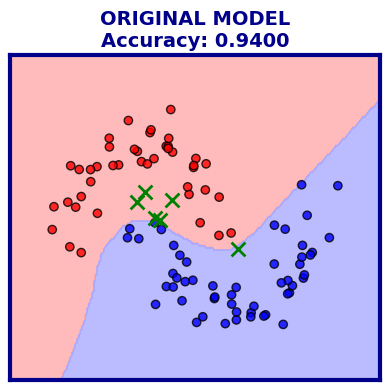

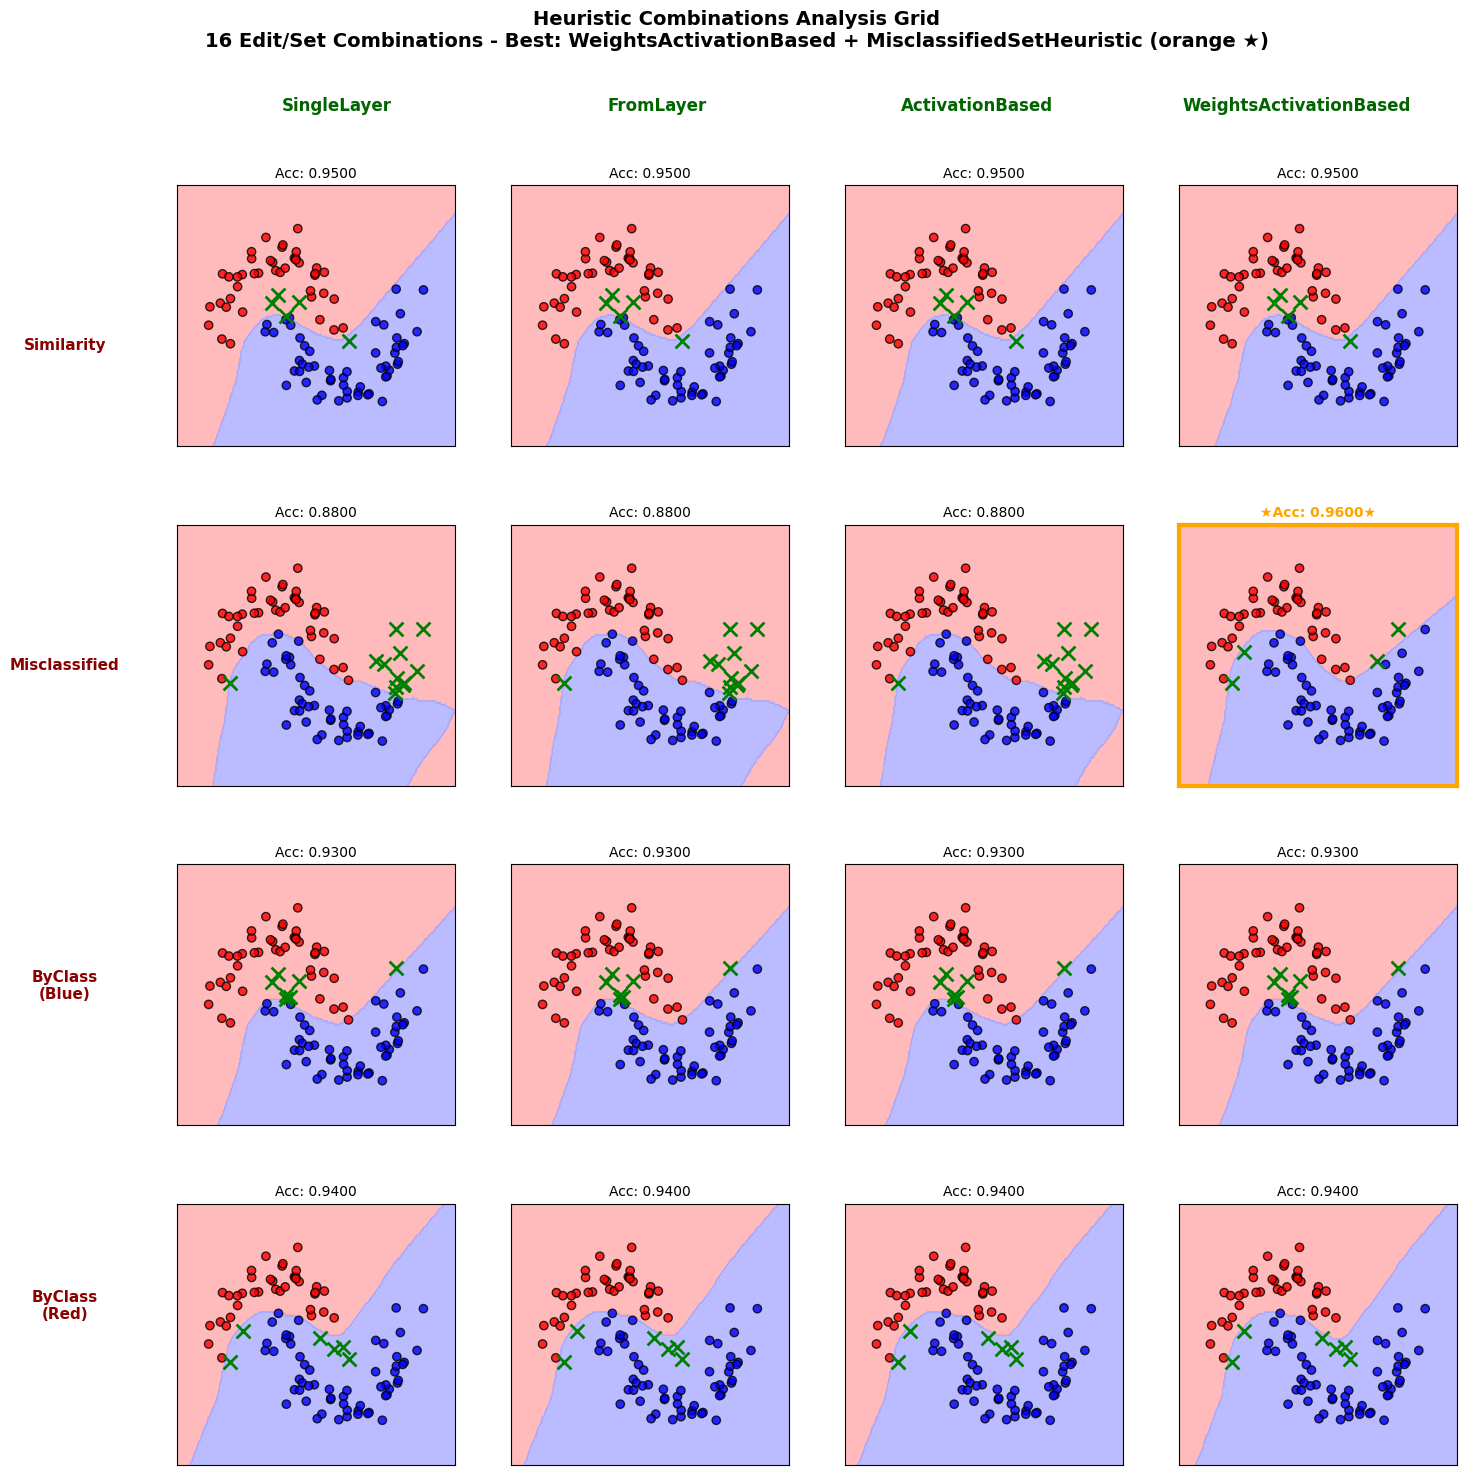


DETAILED RESULTS BY SET HEURISTIC (OPTIMIZED WITH EDITSET_PATH)
Original Model Accuracy: 0.9400
------------------------------------------------------------------------------------------------------------------------

SimilaritySetHeuristic:
  Edit Heuristic          Accuracy   Improvement  Status         
  -----------------------------------------------------------------
  SingleLayer               0.9500     +0.0100                     
  FromLayer                 0.9500     +0.0100                     
  ActivationBased           0.9500     +0.0100                     
  WeightsActivationBased    0.9500     +0.0100                     

MisclassifiedSetHeuristic:
  Edit Heuristic          Accuracy   Improvement  Status         
  -----------------------------------------------------------------
  WeightsActivationBased    0.9600     +0.0200      ★ BEST OVERALL 
  SingleLayer               0.8800     -0.0600                     
  FromLayer                 0.8800     -0.0600       

In [4]:
# Find best combination
if not all_results:
    print("\nNo successful combinations found. Please check the heuristic implementations.")
    exit()

# Create visualization with separate figures
num_edit_heuristics = len(edit_heuristics_options)
num_set_heuristics = len(set_heuristics_options)

# Figure 1: Original Model (same size as individual heuristic plots)
fig1, ax_original = plt.subplots(1, 1, figsize=(4, 4))

# Plot original model
ax_original.contourf(xx, yy, Z, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']), alpha=0.8)
correct_idx = (original_predicted == y.numpy())
ax_original.scatter(X[correct_idx, 0], X[correct_idx, 1], 
                    c=y.numpy()[correct_idx], cmap=ListedColormap(['#FF0000', '#0000FF']), 
                    edgecolors='k', alpha=0.8)
misclass_idx = (original_predicted != y.numpy())
ax_original.scatter(X[misclass_idx, 0], X[misclass_idx, 1], 
                    c='green', marker='x', s=100, linewidths=2)
ax_original.set_title(f"ORIGINAL MODEL\nAccuracy: {original_accuracy:.4f}", 
                        fontweight='bold', fontsize=14, color='darkblue')

# Remove axis labels and ticks for cleaner look
ax_original.set_xticks([])
ax_original.set_yticks([])

# Add border to original model
for spine in ax_original.spines.values():
    spine.set_edgecolor('darkblue')
    spine.set_linewidth(3)

plt.tight_layout()
plt.show()

# Figure 2: Heuristics Grid with better spacing
fig2, axes = plt.subplots(num_set_heuristics, num_edit_heuristics, 
                         figsize=(num_edit_heuristics * 4, num_set_heuristics * 4))

# Plot combinations organized by SetHeuristic (one row per SetHeuristic)
for row, (set_name, _) in enumerate(set_heuristics_options):
    set_results = results_by_set[set_name]
    
    for col, (edit_name, _) in enumerate(edit_heuristics_options):
        ax = axes[row, col]
        
        # Find the result for this combination
        result = None
        for r in set_results:
            if r['edit_heuristic'] == edit_name:
                result = r
                break
        
        if result:
            model = result['model']
            
            with torch.no_grad():
                mesh_output = model(mesh_input)
                Z_result = torch.argmax(mesh_output, dim=1).reshape(xx.shape).detach().numpy()
                outputs = model(X)
                _, predicted = torch.max(outputs.data, 1)
            
            predicted = predicted.numpy()
            
            # Plot decision boundary
            ax.contourf(xx, yy, Z_result, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']), alpha=0.8)
            
            # Plot correct classifications
            correct_idx = (predicted == y.numpy())
            ax.scatter(X[correct_idx, 0], X[correct_idx, 1], 
                        c=y.numpy()[correct_idx], cmap=ListedColormap(['#FF0000', '#0000FF']), 
                        edgecolors='k', alpha=0.8)
            
            # Plot misclassifications
            misclass_idx = (predicted != y.numpy())
            ax.scatter(X[misclass_idx, 0], X[misclass_idx, 1], 
                        c='green', marker='x', s=100, linewidths=2)
            
            # Highlight best model with orange border
            if result == best_result:
                for spine in ax.spines.values():
                    spine.set_edgecolor('orange')
                    spine.set_linewidth(3)
                title_color = 'orange'
                title = f"★Acc: {result['accuracy']:.4f}★"
                fontweight = 'bold'
            else:
                title_color = 'black'
                title = f"Acc: {result['accuracy']:.4f}"
                fontweight = 'normal'
            
            ax.set_title(title, color=title_color, fontweight=fontweight, fontsize=10)
            
            # Remove axis labels and ticks for cleaner look
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            # No result found, hide the subplot
            ax.set_visible(False)

# Adjust spacing to prevent overlaps
plt.subplots_adjust(left=0.15, right=0.95, top=0.85, bottom=0.05, hspace=0.3, wspace=0.2)

# Add column headers (EditHeuristics) with proper spacing
for col, (edit_name, _) in enumerate(edit_heuristics_options):
    # Position headers above the grid with more space
    x_pos = 0.15 + (col + 0.5) * 0.8 / num_edit_heuristics
    fig2.text(x_pos, 0.90, edit_name,
             ha='center', va='center', fontsize=12, fontweight='bold', color='darkgreen')

# Add row headers (SetHeuristics) with proper spacing to avoid intersecting graphs
for row, (set_name, _) in enumerate(set_heuristics_options):
    # Clean up the set name for display
    display_name = set_name.replace('SetHeuristic', '').replace('_', ' ')
    if display_name.startswith('ByClass'):
        if 'Red' in display_name:
            display_name = 'ByClass\n(Red)'
        elif 'Blue' in display_name:
            display_name = 'ByClass\n(Blue)'
    elif display_name == 'Misclassified':
        display_name = 'Misclassified'
    elif display_name == 'Subset':
        display_name = 'Subset'
    elif display_name == 'Similarity':
        display_name = 'Similarity'
    
    # Position labels on the left side with enough margin
    y_pos = 0.85 - (row + 0.5) * 0.8 / num_set_heuristics
    fig2.text(0.08, y_pos, display_name, 
             ha='center', va='center', fontsize=11, fontweight='bold', 
             color='darkred', rotation=0)

# Add overall title for heuristics grid with proper spacing
fig2.suptitle(f'Heuristic Combinations Analysis Grid\n' +
              f'{len(all_results)} Edit/Set Combinations - Best: {best_result["combination"]} (orange ★)', 
              fontsize=14, y=0.96, fontweight='bold')

# Add a subtle background for better visual organization
fig2.patch.set_facecolor('white')
fig2.patch.set_alpha(0.9)

plt.show()

# Print detailed comparison organized by set heuristic
print("\n" + "="*120)
print("DETAILED RESULTS BY SET HEURISTIC (OPTIMIZED WITH EDITSET_PATH)")
print("="*120)
print(f"Original Model Accuracy: {original_accuracy:.4f}")
print("-"*120)

for set_name, set_results in results_by_set.items():
    if set_results:
        print(f"\n{set_name}:")
        print(f"{'  Edit Heuristic':<25} {'Accuracy':<10} {'Improvement':<12} {'Status':<15}")
        print("  " + "-"*65)
        
        for result in sorted(set_results, key=lambda x: x['accuracy'], reverse=True):
            improvement = result['accuracy'] - original_accuracy
            improvement_str = f"+{improvement:.4f}" if improvement > 0 else f"{improvement:.4f}"
            status = "★ BEST OVERALL" if result == best_result else ""
            print(f"  {result['edit_heuristic']:<25} {result['accuracy']:<10.4f} {improvement_str:<12} {status:<15}")